In [1]:
from os.path import dirname, join
from pprint import pprint
import os
import pydicom
from PIL import Image
import numpy as np
import ipyplot
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu, threshold_multiotsu
import pandas as pd
from sklearn.model_selection import KFold
import collections, numpy
import h5py
import seaborn as sns
import SimpleITK as sitk
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm
import pylab as py
from sklearn.preprocessing import minmax_scale
from os.path import join as opj
from collections import Counter
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
import shutil
import io
from PIL import Image, ImageFont, ImageDraw
import sys
sys.path.append('/home/ws/oc9627/cerebral_organoid_quant_mri')

from scripts.utils.constants import MRI_ORG_LOC_GT_DIR, MRI_CYST_LOC_GT_DIR, CSV_GLOBAL_CYST_ANNOT, DWMRI_SEQUENCES, MRI_CYST_SEG_FILES_3DUNET
from scripts.utils.SegmentationPerformanceExtractor import SegmentationPerformanceExtractor
from scripts.utils.SegmentationOverlayVisualizer import SegmentationOverlayVisualizer
from scripts.utils.io_utils import get_orig_imgs, get_masks
from scripts.utils.global_cyst_classification import get_compactness
from scripts.utils.metrics import calculate_roc_auc
from scripts.utils.dwmri import get_metrics_global_cyst_seg_dw_mri

from scripts.utils.visualization import plot_compactness, plot_examples_lq_hq_organoids, plot_trace_lq_hq_mean_org_int, plot_correlation_compactness_cysticity

wdir = '/home/ws/oc9627/cerebral_organoid_quant_mri'
os.chdir(wdir)

# Organoid segmentation

#### extract results on test set

In [2]:
pred_dir = 'results/organoid_segmentation/checkpoint_files_3DUNet_run1/all_predictions_on_test_sets'
gt_dir = MRI_ORG_LOC_GT_DIR

Test Dice 0.92±0.06 (mean±SD)


/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = self.df.drop_duplicates().mean()['Test Dice']
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sd = self.df.drop_duplicates().std()['Test Dice']


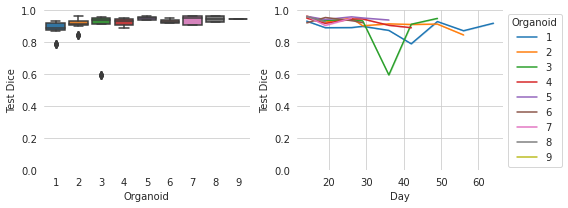

In [4]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/organoid_segmentation/plots/organoid_seg_performance.png')
spe.print_test_dice_mean_sd()

### run 2

Test Dice 0.89±0.09 (mean±SD)


/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = self.df.drop_duplicates().mean()['Test Dice']
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sd = self.df.drop_duplicates().std()['Test Dice']


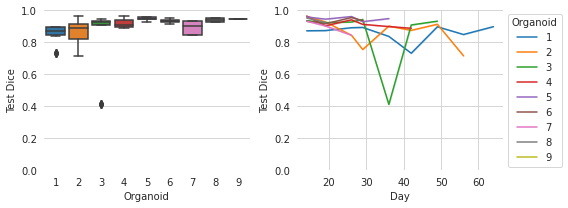

In [7]:
pred_dir = 'results/organoid_segmentation/checkpoint_dirs/all_predictions_on_test_sets'
gt_dir = MRI_ORG_LOC_GT_DIR

spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance()
spe.print_test_dice_mean_sd()

#### plot weakest, intermediate and best prediction

In [3]:
imgs = get_orig_imgs(kind='mri')

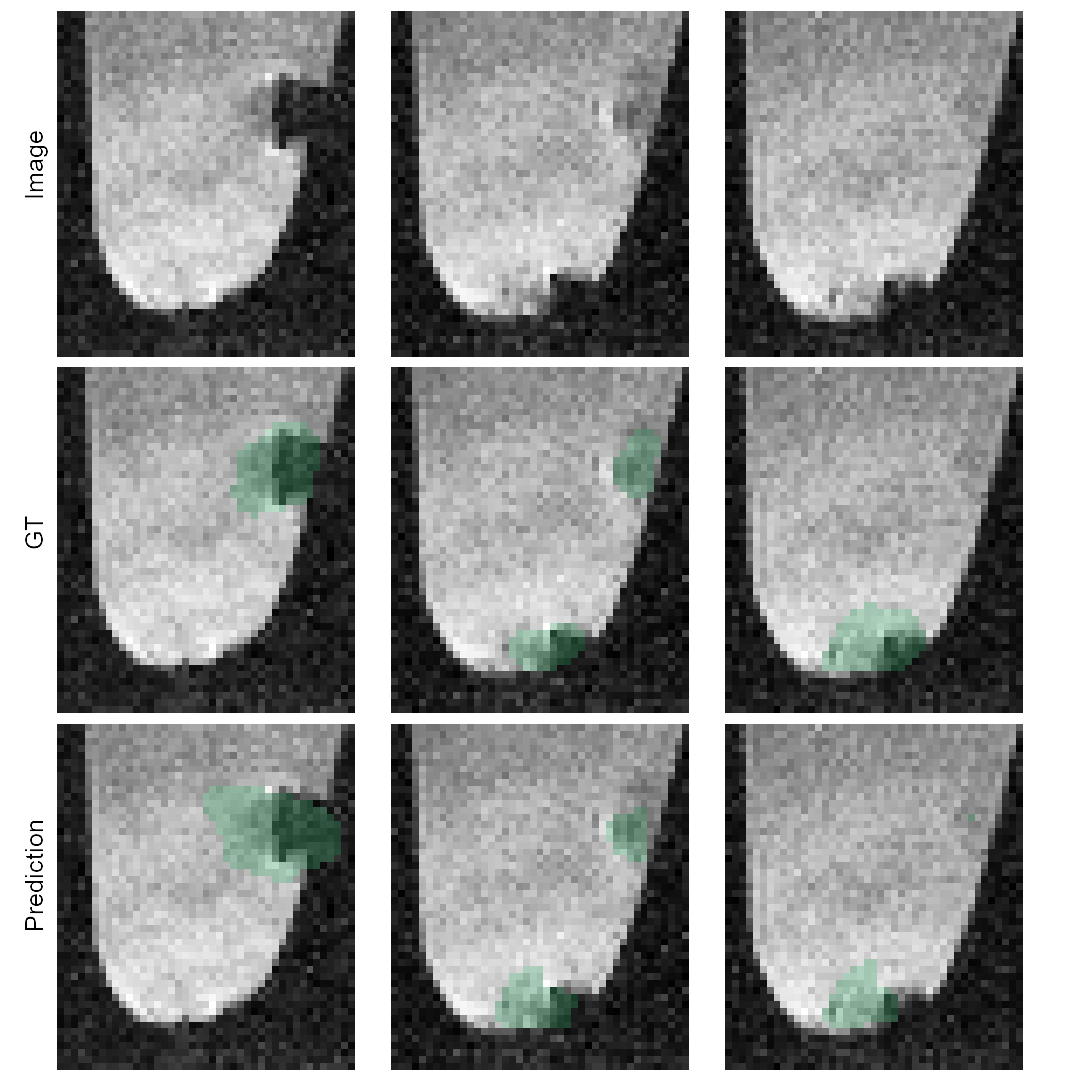

In [10]:
# weakest prediction
sov = SegmentationOverlayVisualizer(imgs,
                                    org_id = 'org3_0609', 
                                    org_loc = [15, 65, 65, 108], 
                                    gt_dir = MRI_ORG_LOC_GT_DIR,
                                    pred_dir = pred_dir,
                                    px_threshold=0,
                                    planes='sagittal',
                                    keep_planes=[44, 47, 50],
                                    rot_img=270)
display(sov.plot_segmentation_overlays())


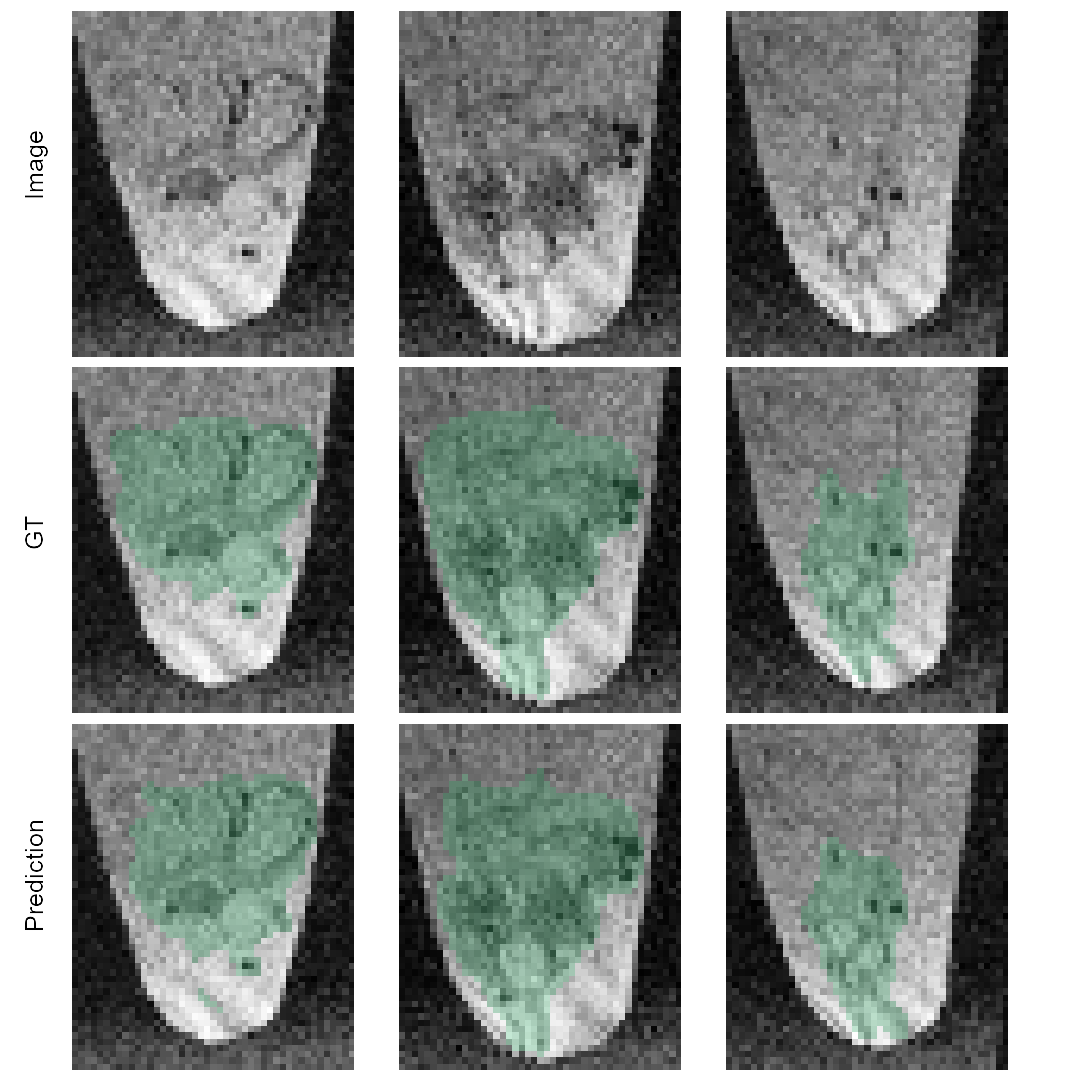

In [9]:
# intermediate prediction
sov = SegmentationOverlayVisualizer(imgs,
                                 org_id = 'org2_0615', 
                                 org_loc = [20, 75, 30, 75], 
                                 gt_dir = MRI_ORG_LOC_GT_DIR,
                                 pred_dir = pred_dir,
                                 px_threshold=0,
                                 planes='sagittal',
                                 keep_planes=[40, 50, 58],
                                 rot_img=270)
display(sov.plot_segmentation_overlays())

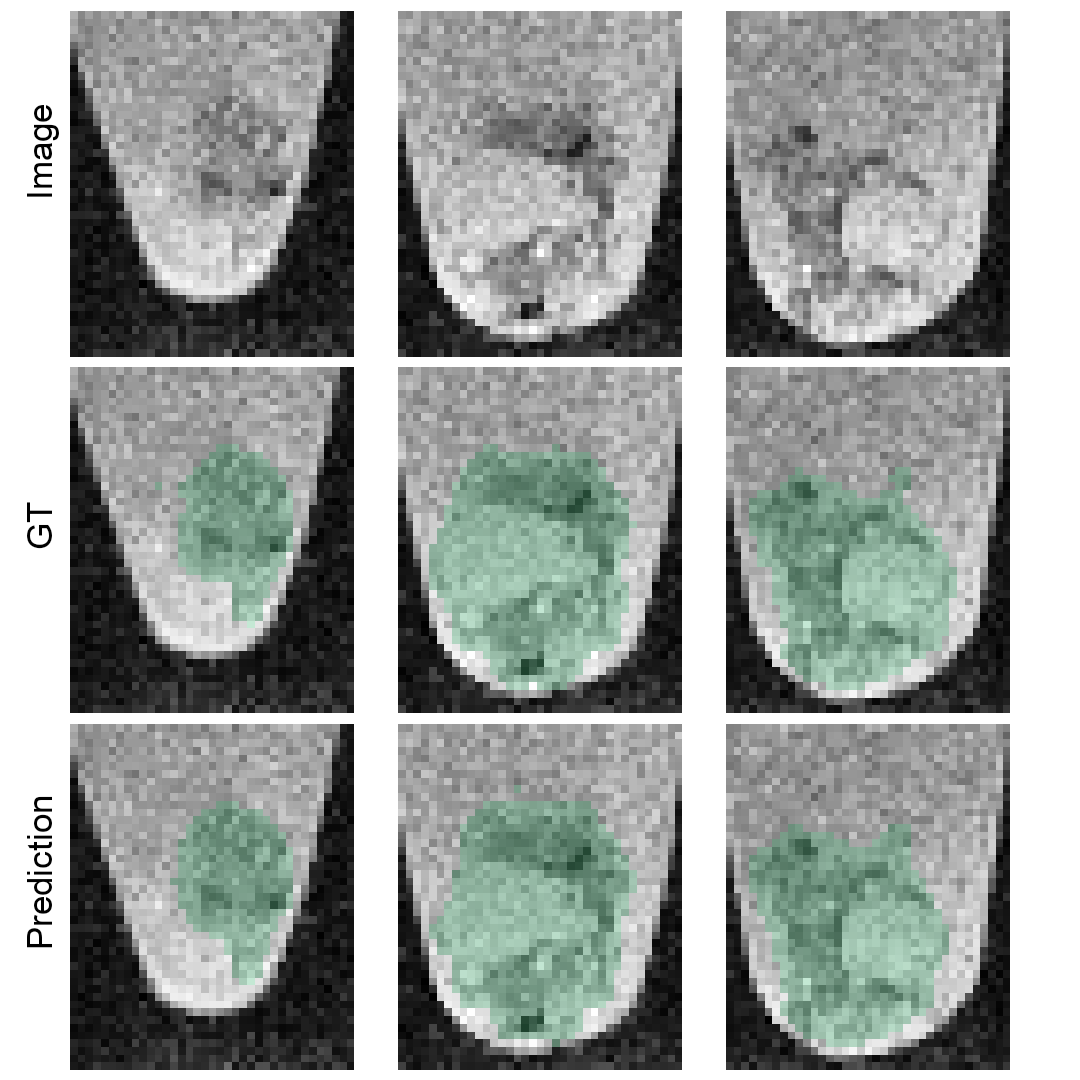

In [4]:
# strongest prediction
sov = SegmentationOverlayVisualizer(imgs,
                                 org_id = 'org5_0530', 
                                 org_loc = [20, 65, 38, 75], 
                                 gt_dir = MRI_ORG_LOC_GT_DIR,
                                 pred_dir = pred_dir,
                                 px_threshold=0,
                                 planes='sagittal',
                                 keep_planes=[34, 40, 52],
                                 rot_img=270,
                                 save_to='results/organoid_segmentation/plots/organoid_seg_overlay_org5_0530.png')
img = sov.plot_segmentation_overlays()
display(img)

# Global cyst classification

#### Calculate mean organoid intensities and compactness

In [2]:
df = get_compactness()

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:41: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eppendorf_ma

#### Calculate ROC AUC and visualize class separation

ROC AUC for mean organoid intensity:	0.64
ROC AUC for Compactness:		0.98


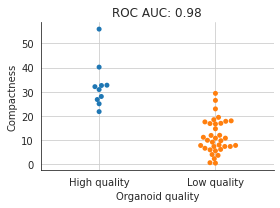

In [3]:
roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, 
                 roc_auc_compactness, 
                 save_to='results/global_cyst_classification/compactness_separates_lq_hq_organoids.png')

#### Visualize examples of LQ and HQ organoids

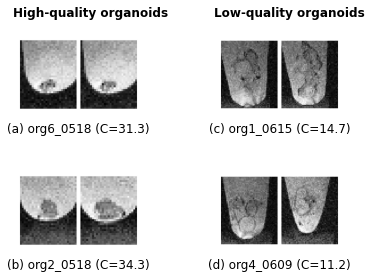

In [2]:
org_ids = ['org6_0518', 'org2_0518', 'org1_0615', 'org4_0609']
compactnesses = [31.3, 34.3, 14.7, 11.2]
# two selected sagittal planes for each organoid
# other ranges to crop images to EV boundaries for better visibility (manually extracted) 
org_locs_planes = [(['88-117', '59', '32-67'], ['88-117', '60', '32-67']),
                   (['40-69', '41', '40-75'], ['40-69', '45', '40-75']),
                   (['5-55', '58', '15-90'], ['5-55', '61', '15-90']),
                   (['17-67', '36', '15-85'], ['17-67', '53', '15-85'])]
plot_examples_lq_hq_organoids(org_ids, 
                              compactnesses,
                              org_locs_planes,
                              save_to='results/global_cyst_classification/examples_lq_hq_organoids.png')

#### DW-MRI to probe tissue characteristics

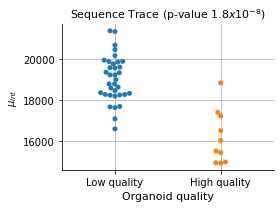

In [2]:
plot_trace_lq_hq_mean_org_int(save_to='results/global_cyst_classification/trace_mean_org_intensities.png')

# Local cyst classification

#### extract results

In [6]:
pred_dir_local_cysts = 'results/local_cyst_segmentation/checkpoint_files_3DUNet_run1/all_predictions_on_test_sets'
gt_dir = MRI_CYST_LOC_GT_DIR

Test Dice 0.63±0.15 (mean±SD)


/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = self.df.drop_duplicates().mean()['Test Dice']
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/SegmentationPerformanceExtractor.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sd = self.df.drop_duplicates().std()['Test Dice']


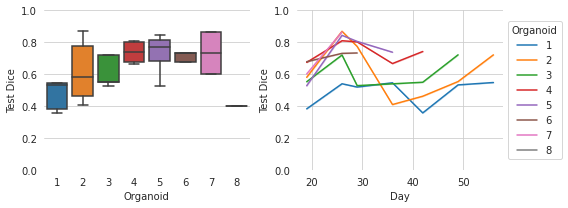

In [15]:
spe = SegmentationPerformanceExtractor(pred_dir = pred_dir,
                                       gt_dir = gt_dir)
spe.extract_test_performance()
spe.plot_test_performance(save_to='results/local_cyst_segmentation/plots/local_cyst_seg_performance.png')
spe.print_test_dice_mean_sd()

#### visualize weakest, intermediate and strongest prediction

In [3]:
imgs = get_orig_imgs(kind='mri')

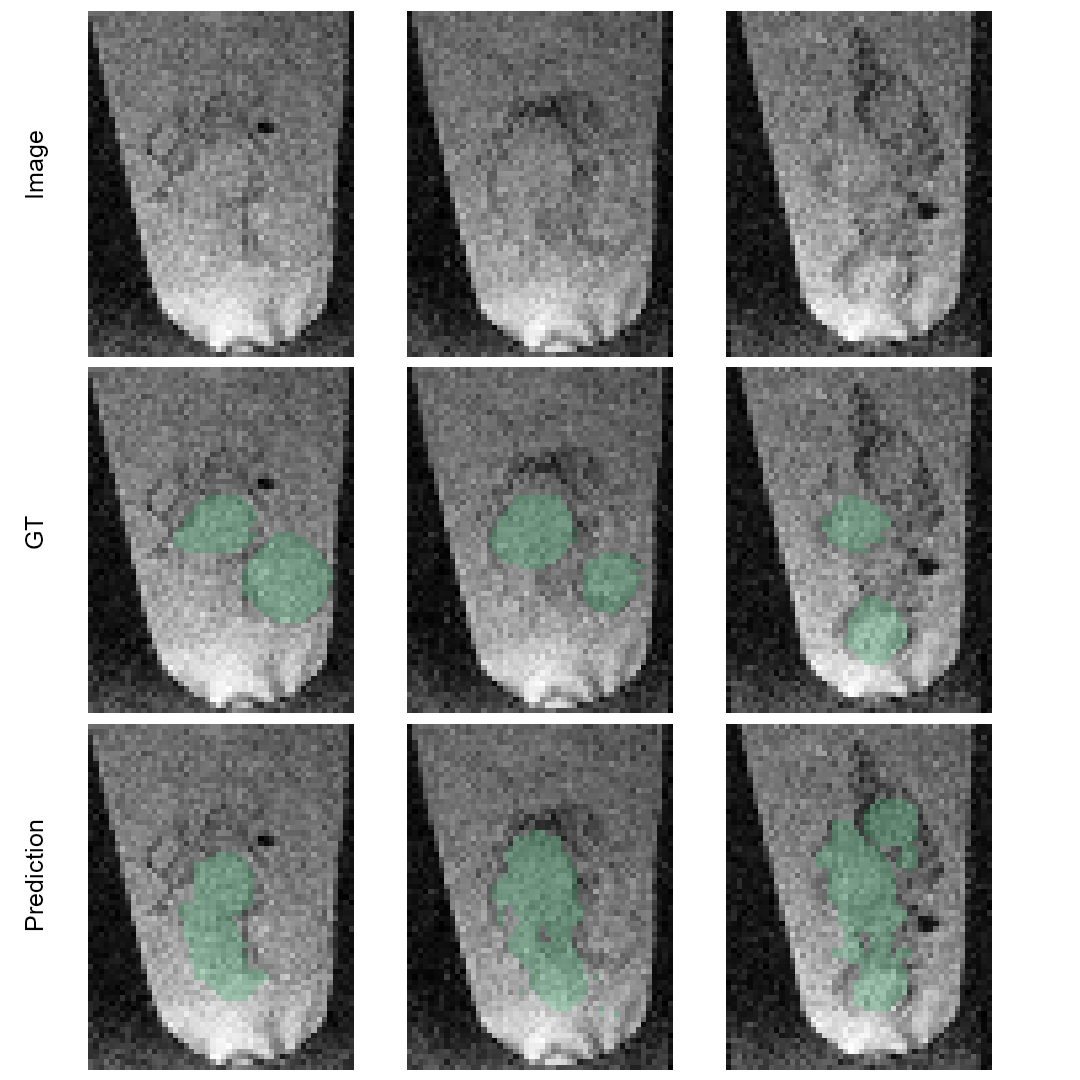

In [7]:
# weakest prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org1_0615', 
                 org_loc = [10, 75, 10, 60],
                 gt_dir = gt_dir,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 keep_planes=[60, 55, 51],
                 rot_img=270)
display(sov.plot_segmentation_overlays())

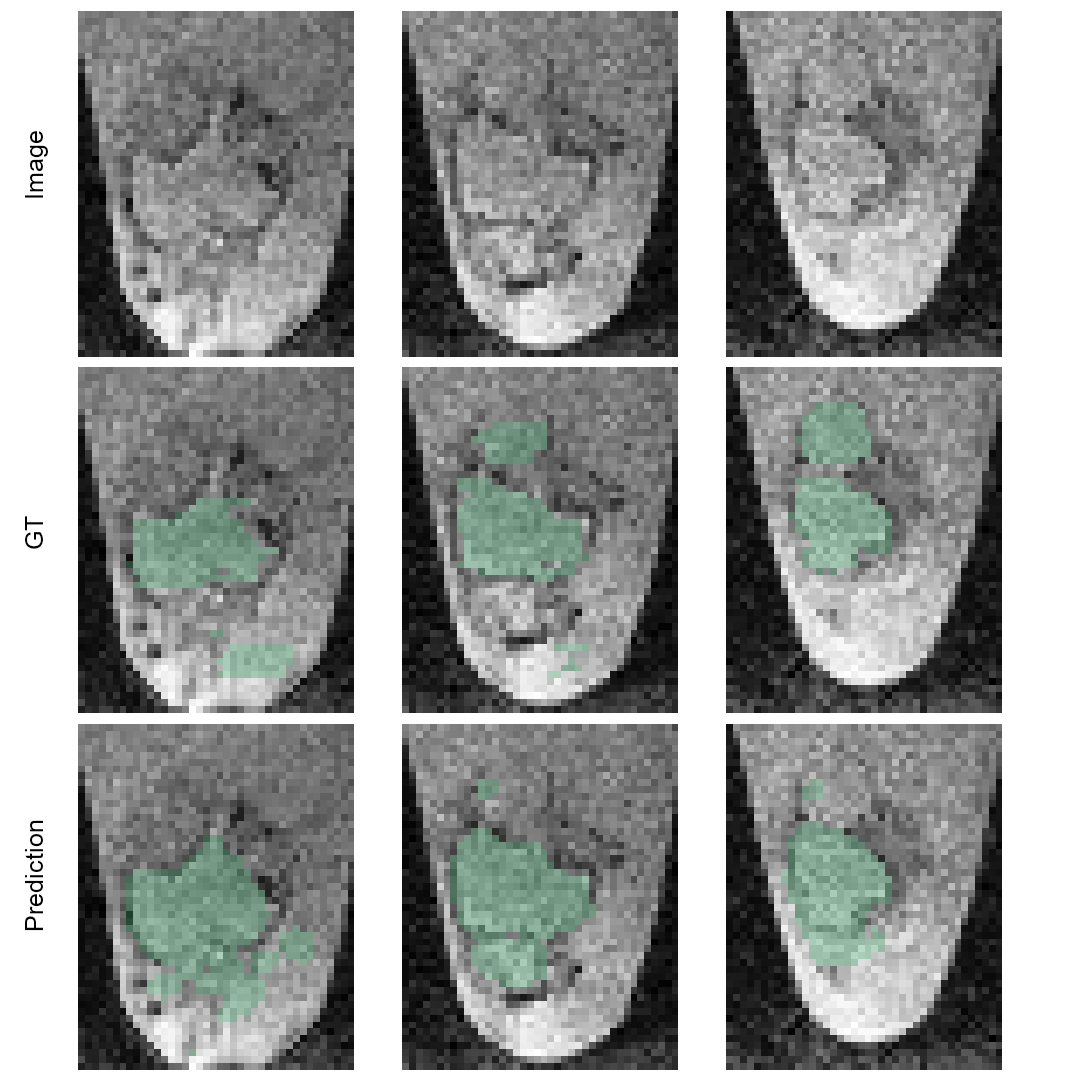

In [8]:
# intermediate prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org4_0609', 
                 org_loc=[20, 70, 25, 65], 
                 gt_dir = gt_dir,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[52, 49, 42],
                 rot_img=270)
display(sov.plot_segmentation_overlays())

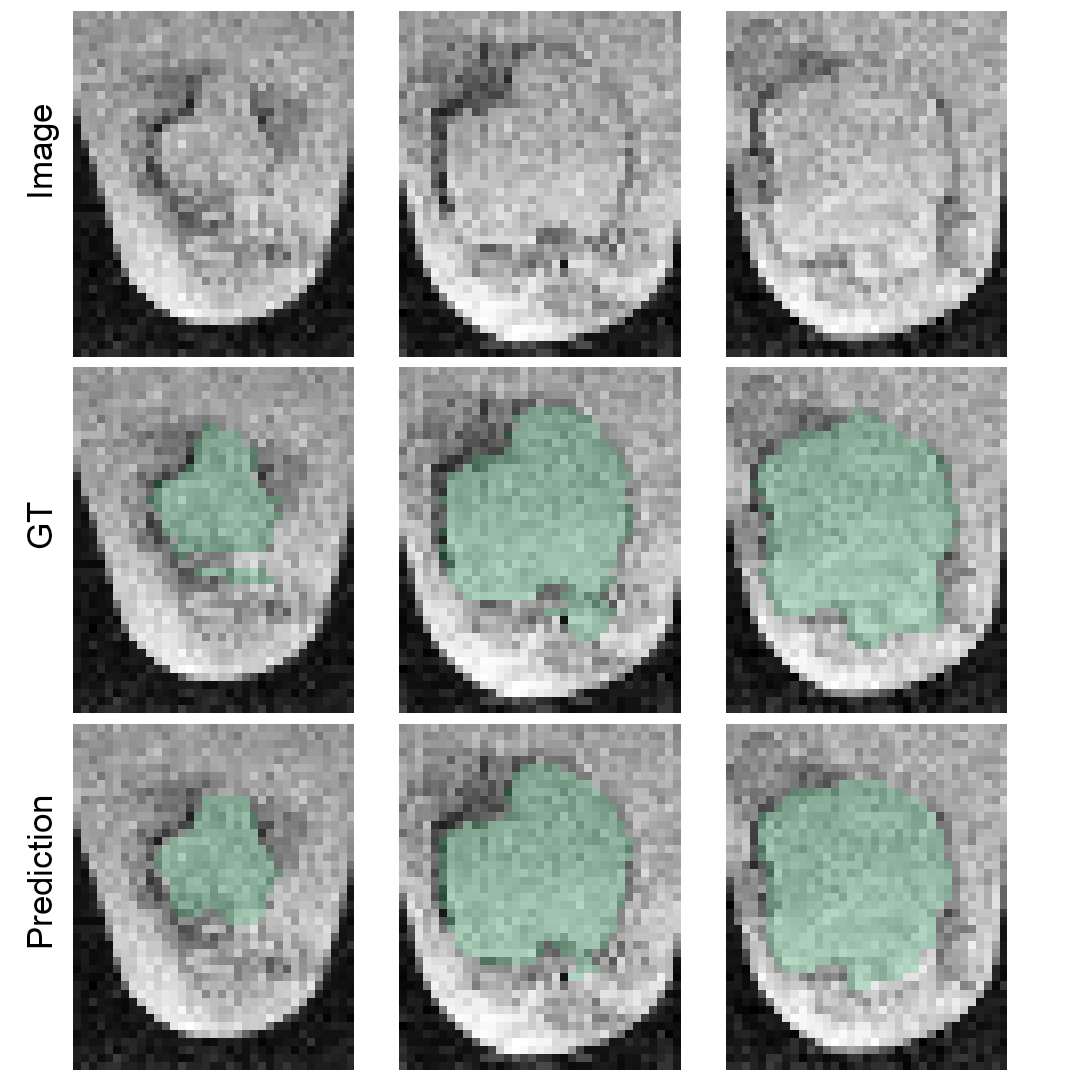

In [7]:
# strongest prediction
sov = SegmentationOverlayVisualizer(imgs,
                 org_id = 'org7_0530', 
                 org_loc=[22, 65, 20, 55], 
                 gt_dir = MRI_CYST_LOC_GT_DIR,
                 pred_dir = pred_dir_local_cysts,
                 planes='sagittal',
                 px_threshold=0,
                 keep_planes=[49, 56, 63],
                 rot_img=270,
                 save_to='results/local_cyst_segmentation/plots/cyst_seg_overlay_org7_0530.png')
display(sov.plot_segmentation_overlays())

# Supplementary

### organoid segmentation

#### plot organoid growth over time

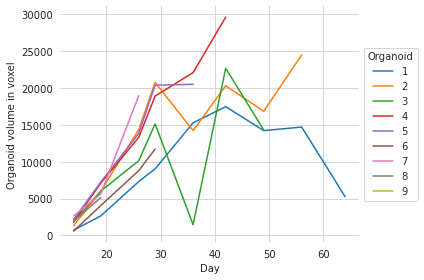

In [536]:
plot_organoid_growth_over_time()
plt.savefig('figures/organoid_growth_over_time.png', dpi=400)

### global cyst classification

#### correlation of compactness with cysticity from local cyst segmentations

/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:43: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.stack(np.array(eppendorf_masks)), 0, -1)
/home/ws/oc9627/cerebral_organoid_quant_mri/scripts/utils/global_cyst_classification.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.stack(np.array(eppendorf_masks)), 0, -1)


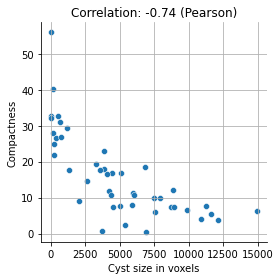

In [2]:
plot_correlation_compactness_cysticity(save_to='results/local_cyst_segmentation/plots/correlation_compactness_cysticity.png')

#### values for predicted organoid locations (3D U-Net)

/tmp/ipykernel_2668584/206784105.py:65: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)
/tmp/ipykernel_2668584/206784105.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  eppendorf_masks_stacked = np.moveaxis(np.stack(np.array(eppendorf_masks)), 0, -1)


ROC AUC for mean organoid intensity:	0.6485714285714286
ROC AUC for Compactness:		0.9514285714285714


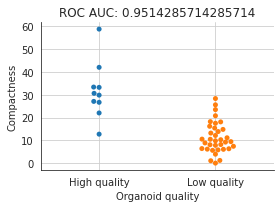

In [432]:
imgs = get_orig_imgs()
gt = get_organoid_locations(kind='predicted')
otsu, _ = get_all_otsu_masks(imgs, gt)

df = get_org_mean_and_compactness(imgs, 
                                  org_loc=gt, 
                                  otsu=otsu)
quality_annot = pd.read_csv('mri_paper_data/global_cyst_classification_annotations.csv')
df = df.merge(quality_annot)

roc_auc_moi = calculate_roc_auc(df, col='mean_organoid_intensity')
roc_auc_compactness = calculate_roc_auc(df, col='compactness')

print(f'ROC AUC for mean organoid intensity:\t{roc_auc_moi}')
print(f'ROC AUC for Compactness:\t\t{roc_auc_compactness}')

plot_compactness(df, roc_auc_compactness)

### ROC AUCs for DW-MRI

In [8]:
df_dwmri_metrics, _ = get_metrics_global_cyst_seg_dw_mri()
df_dwmri_metrics['ROC AUC'] = df_dwmri_metrics['ROC AUC'].map('{:,.2f}'.format)
df_dwmri_metrics['P-value'] = df_dwmri_metrics['P-value'].map('{:,.2E}'.format)
df_dwmri_metrics
# df_dwmri_metrics.to_csv('metrics_global_cyst_seg_dwmri.csv', index=False, sep=';')